In [103]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss, loss_ddqn

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt

ImportError: cannot import name 'loss_ddqn' from 'utils' (d:\RL\cw\RL_CW2\utils.py)

In [17]:
def train(epsilon, layers, learning_rate, buffer_size, batch_size, update_target_freq):

    NUM_RUNS = 10
    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(NUM_RUNS):
        print(f"Starting run {run+1} of {NUM_RUNS}")
        policy_net = DQN(layers)
        target_net = DQN(layers)
        update_target(target_net, policy_net)
        target_net.eval()
        EPS_START = epsilon
        EPS_END = 0.05
        EPS_DECAY = 50
        optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
        memory = ReplayBuffer(buffer_size)

        steps_done = 0

        episode_durations = []

        for i_episode in range(300):
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", 300)

            observation, info = env.reset()
            state = torch.tensor(observation).float()

            done = False
            terminated = False
            t = 0
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY), policy_net, state)
                
                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < batch_size:
                    transitions = memory.sample(batch_size)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    for param in policy_net.parameters():
                        param.grad.data.clamp_(-1, 1)
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            steps_done += 1
            if i_episode % update_target_freq == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results

Grid Search, it is time consuming, uncomment to use

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

[]

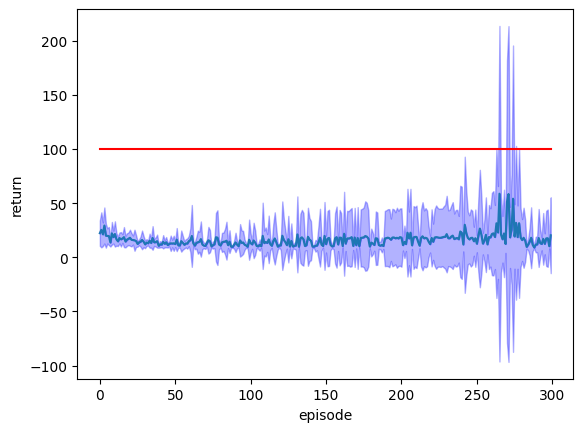

In [22]:

epsilon_range = [0.9]
layers_range = [[4, 256, 256, 2]]
learning_rate_range = [0.001, 0.0001, 0.1]
buffer_size_range = [10000]
batch_size_range = [256]
update_target_freq_range = [5, 10, 20]

def hyperparameter_tuning(epsilon_range, layers_range, learning_rate_range, buffer_size_range, batch_size_range, update_target_freq_range):
    results = []
    for epsilon in epsilon_range:
        for layers in layers_range:
            for learning_rate in learning_rate_range:

                for buffer_size in buffer_size_range:
                    for batch_size in batch_size_range:
                        for update_target_freq in update_target_freq_range:
                            
                            res = torch.tensor(train(epsilon, layers, learning_rate, buffer_size, batch_size, update_target_freq))
                            means = res.float().mean(0)
                            stds = res.float().std(0)
                            plt.clf()
                            # plt.figure()
                            plt.plot(torch.arange(300), means)
                            plt.ylabel("return")
                            plt.xlabel("episode")
                            plt.fill_between(torch.arange(300), means, means + stds, alpha=0.3, color='b')
                            plt.fill_between(torch.arange(300), means, means - stds, alpha=0.3, color='b')
                            # baseline at 100
                            plt.plot(torch.arange(300), torch.ones(300)*100, color='r')
                            #save the graph
                            plt.savefig("{}_{}_{}_{}_{}_{}.png".format(epsilon, layers, learning_rate, buffer_size, batch_size, update_target_freq))

    return results


# hyperparameter_tuning(epsilon_range, layers_range, learning_rate_range, buffer_size_range, batch_size_range, update_target_freq_range)

In [25]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots
env = gym.make('CartPole-v1')
# Make sure to include appropriate labels and/or legends when presenting your plot
layers = [4, 256, 256, 2]
epsilon = 0.9
learning_rate = 0.0001
buffer_size = 10000
batch_size = 256
update_target_freq = 20


policy_net = DQN(layers)
target_net = DQN(layers)
update_target(target_net, policy_net)
target_net.eval()
EPS_START = epsilon
EPS_END = 0.05
EPS_DECAY = 50
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = ReplayBuffer(buffer_size)

steps_done = 0

episode_durations = []

for i_episode in range(300):
    if (i_episode+1) % 50 == 0:
        print("episode ", i_episode+1, "/", 300)

    observation, info = env.reset()
    state = torch.tensor(observation).float()

    done = False
    terminated = False
    t = 0
    while not (done or terminated):

        # Select and perform an action
        action = epsilon_greedy(EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY), policy_net, state)
        
        observation, reward, done, terminated, info = env.step(action)
        reward = torch.tensor([reward])
        action = torch.tensor([action])
        next_state = torch.tensor(observation).reshape(-1).float()

        memory.push([state, action, next_state, reward, torch.tensor([done])])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if not len(memory.buffer) < batch_size:
            transitions = memory.sample(batch_size)
            state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
            # Compute loss
            mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
            # Optimize the model
            optimizer.zero_grad()
            mse_loss.backward()
            for param in policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            optimizer.step()
        
        if done or terminated:
            episode_durations.append(t + 1)
        t += 1
    # Update the target network, copying all weights and biases in DQN
    steps_done += 1
    if i_episode % update_target_freq == 0: 
        update_target(target_net, policy_net)
        


episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300


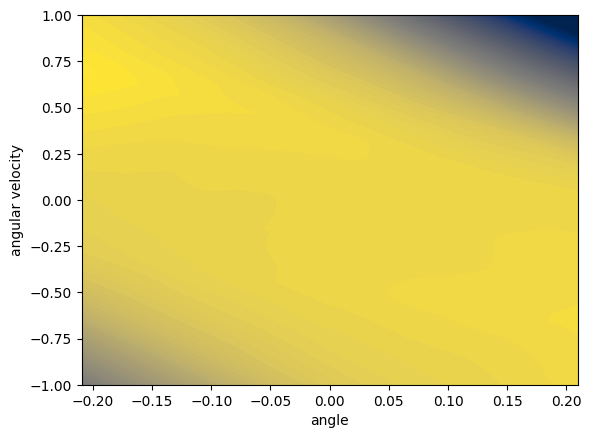

In [28]:
# policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 1     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for i, angle in enumerate(angles):
    for j, omega in enumerate(omegas):
        state = torch.tensor([0., 0., angle, omega])
        with torch.no_grad():
            q_vals = policy_net(state)
            greedy_action = q_vals.argmax()
            greedy_q_array[i, j] = q_vals[greedy_action]
            policy_array[i, j] = greedy_action
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
plt.xlabel("angle")
plt.ylabel("angular velocity")
plt.show()

tensor([[15.4822, 15.4920, 15.4989,  ...,  0.0000,  0.0000,  0.0000],
        [15.4642, 15.4742, 15.4828,  ...,  0.0000,  0.0000,  0.0000],
        [15.4464, 15.4564, 15.4663,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 8.3008,  8.5858,  8.8584,  ..., 15.7043, 15.6542, 15.6015],
        [ 8.1032,  8.4019,  8.6742,  ..., 15.7394, 15.6917, 15.6390],
        [ 7.9042,  8.2047,  8.4891,  ..., 15.7718, 15.7274, 15.6765]])


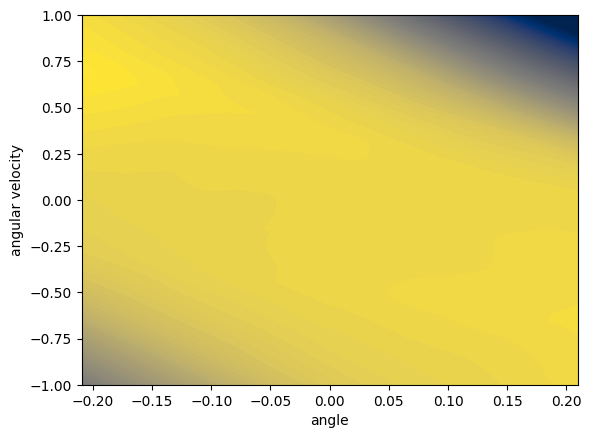

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])


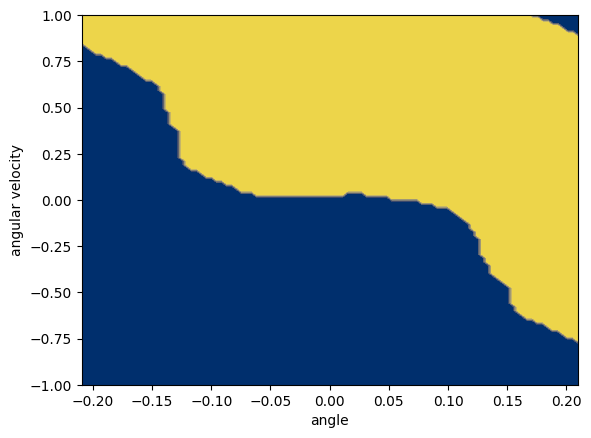

tensor([[15.6010, 15.5785, 15.5549,  ...,  0.0000,  0.0000,  0.0000],
        [15.5958, 15.5736, 15.5524,  ...,  0.0000,  0.0000,  0.0000],
        [15.5908, 15.5694, 15.5482,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [12.9600, 13.1544, 13.3452,  ..., 12.1020, 11.8879, 11.6728],
        [12.8322, 13.0342, 13.2282,  ..., 12.2413, 12.0280, 11.8146],
        [12.7027, 12.9076, 13.1104,  ..., 12.3787, 12.1679, 11.9550]])


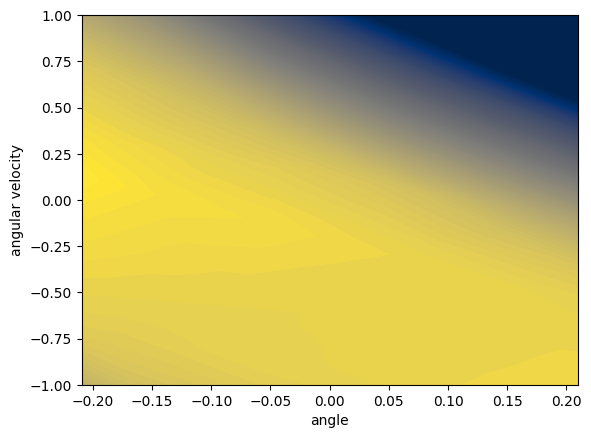

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])


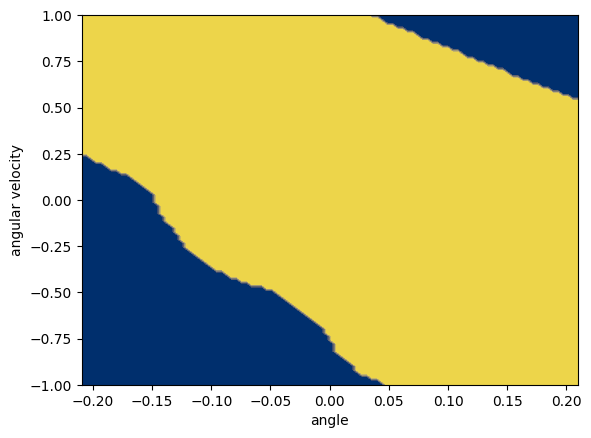

tensor([[14.5951, 14.4753, 14.3167,  ...,  0.0000,  0.0000,  0.0000],
        [14.6305, 14.5106, 14.3837,  ...,  0.0000,  0.0000,  0.0000],
        [14.6660, 14.5462, 14.4201,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [14.9184, 14.9742, 15.0368,  ...,  3.8682,  3.5762,  3.2916],
        [14.8841, 14.9407, 15.0048,  ...,  4.0504,  3.7608,  3.4767],
        [14.8499, 14.9089, 14.9733,  ...,  4.2362,  3.9461,  3.6615]])


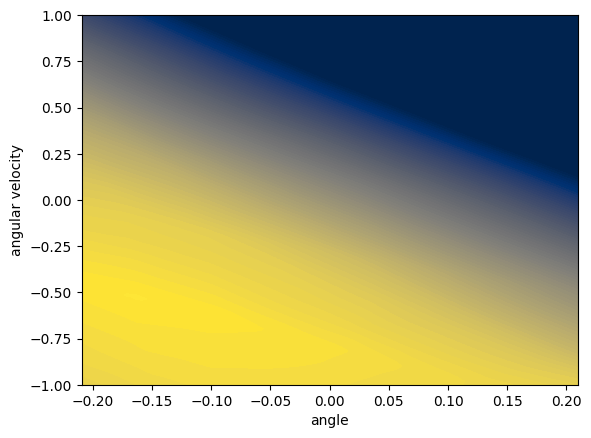

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])


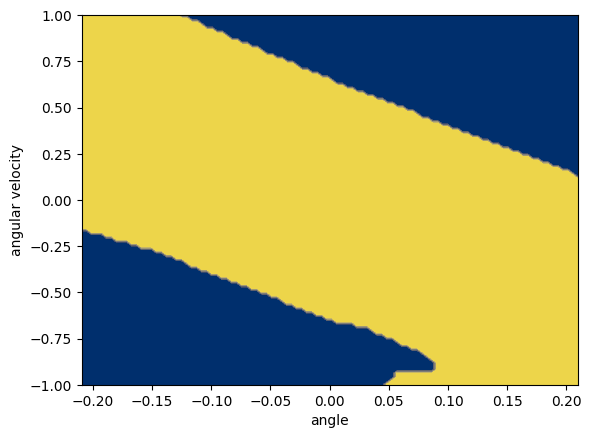

tensor([[ 2.9183,  2.6584,  2.3984,  ...,  0.0000,  0.0000,  0.0000],
        [ 3.0327,  2.7728,  2.5128,  ...,  0.0000,  0.0000,  0.0000],
        [ 3.1471,  2.8872,  2.6273,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [12.7481, 12.6047, 12.4542,  ...,  0.0000,  0.0000,  0.0000],
        [12.8026, 12.6688, 12.5228,  ...,  0.0000,  0.0000,  0.0000],
        [12.8514, 12.7187, 12.5826,  ...,  0.0000,  0.0000,  0.0000]])


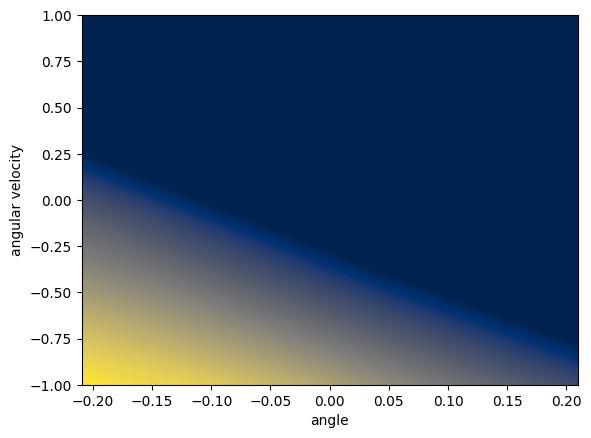

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


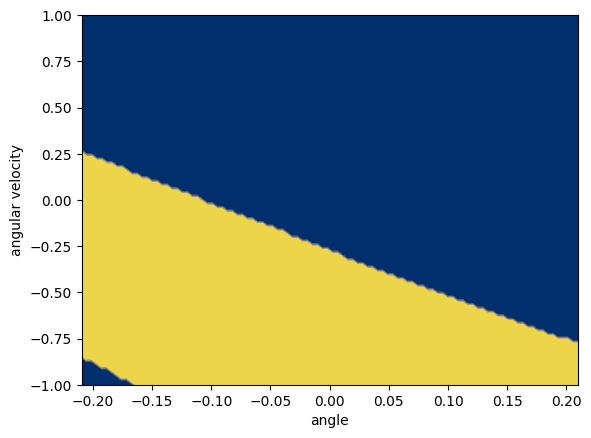

In [40]:
def plot_graphs(velocity,q):
    angle_range = .2095 # you may modify this range
    omega_range = 1     # you may modify this range

    angle_samples = 100
    omega_samples = 100
    angles = torch.linspace(angle_range, -angle_range, angle_samples)
    omegas = torch.linspace(-omega_range, omega_range, omega_samples)

    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., velocity , angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    if q:
        print(greedy_q_array)
        plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
    else:
        print(policy_array)
        plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
    plt.xlabel("angle")
    plt.ylabel("angular velocity")
    # plt.savefig("{}_{}.png".format(velocity,q))
    plt.show()
plot_graphs(0, True)

plot_graphs(0, False)

plot_graphs(0.5,True)

plot_graphs(0.5,False)


plot_graphs(1,True)

plot_graphs(1,False)


plot_graphs(2,True)

plot_graphs(2,False)



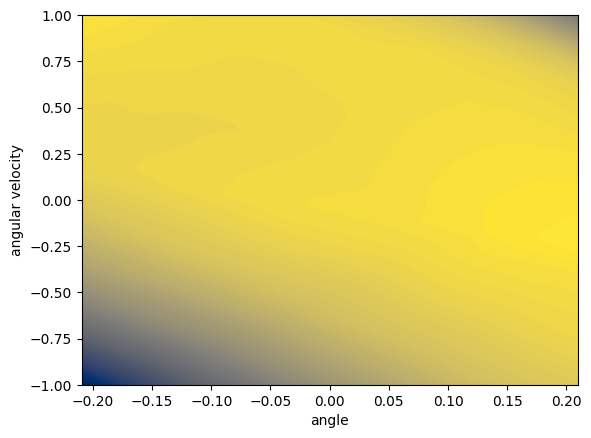

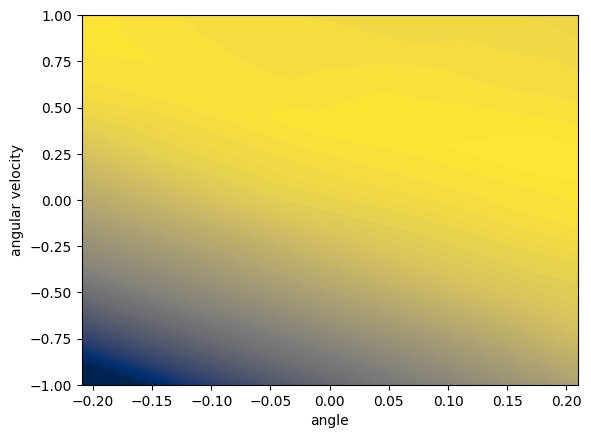

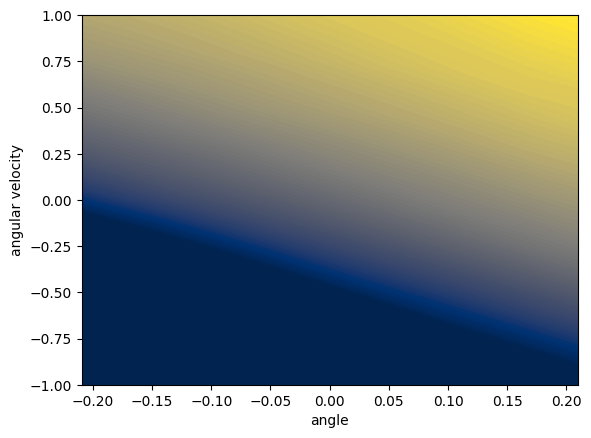

In [39]:
plot_graphs(-0.5,True)
plot_graphs(-1,True)
plot_graphs(-2,True)

In [46]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots
env = gym.make('CartPole-v1')
# Make sure to include appropriate labels and/or legends when presenting your plot
layers = [4, 256, 256, 2]
epsilon = 0.9
learning_rate = 0.0001
buffer_size = 10000
batch_size = 256
update_target_freq = 20

NUM_RUNS = 10
runs_results = []

# env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    policy_net = DQN(layers)
    target_net = DQN(layers)
    update_target(target_net, policy_net)
    target_net.eval()
    EPS_START = epsilon
    EPS_END = 0.05
    EPS_DECAY = 50
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    memory = ReplayBuffer(buffer_size)

    steps_done = 0

    episode_durations = []

    for i_episode in range(600):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", 300)

        observation, info = env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            epsilon_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            action = epsilon_greedy(epsilon_threshold, policy_net, state)
            
            observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < batch_size:
                transitions = memory.sample(batch_size)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                for param in policy_net.parameters():
                    param.grad.data.clamp_(-1, 1)
                optimizer.step()
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        steps_done += 1
        if i_episode % update_target_freq == 0: 
            update_target(target_net, policy_net)
    runs_results.append(episode_durations)
    #save the model
    torch.save(policy_net.state_dict(), "model_DDQN_{}.pth".format(run))



Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
episode  350 / 300
episode  400 / 300
episode  450 / 300
episode  500 / 300
episode  550 / 300
episode  600 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
episode  350 / 300
episode  400 / 300
episode  450 / 300
episode  500 / 300
episode  550 / 300
episode  600 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
episode  350 / 300
episode  400 / 300
episode  450 / 300
episode  500 / 300
episode  550 / 300
episode  600 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
episode  350 / 300
episode  400 / 300
episode  450 / 300
episode  500 / 300
episode  550 / 300
episode  600 / 300
Starting

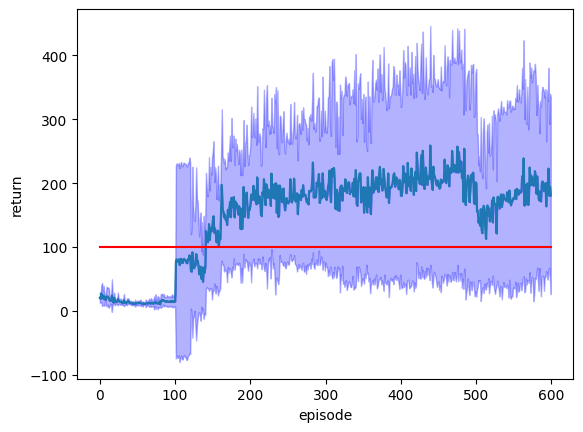

In [47]:

# Plot the results
res = torch.tensor(runs_results)
means = res.float().mean(0)
stds = res.float().std(0)
plt.clf()
# plt.figure()
plt.plot(torch.arange(600), means)
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(torch.arange(600), means, means + stds, alpha=0.3, color='b')
plt.fill_between(torch.arange(600), means, means - stds, alpha=0.3, color='b')
# baseline at 100
plt.plot(torch.arange(600), torch.ones(600)*100, color='r')

In [48]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots
env = gym.make('CartPole-v1')
# Make sure to include appropriate labels and/or legends when presenting your plot
layers = [4, 256, 256, 2]
epsilon = 0.9
learning_rate = 0.0001
buffer_size = 10000
batch_size = 256
update_target_freq = 20

NUM_RUNS = 10
runs_results = []

# env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    policy_net = DQN(layers)
    target_net = DQN(layers)
    update_target(target_net, policy_net)
    target_net.eval()
    EPS_START = epsilon
    EPS_END = 0.05
    EPS_DECAY = 50
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    memory = ReplayBuffer(buffer_size)

    steps_done = 0

    episode_durations = []

    for i_episode in range(600):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", 600)

        observation, info = env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            epsilon_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            action = epsilon_greedy(epsilon_threshold, policy_net, state)
            
            observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < batch_size:
                transitions = memory.sample(batch_size)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss_ddqn(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                for param in policy_net.parameters():
                    param.grad.data.clamp_(-1, 1)
                optimizer.step()
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        steps_done += 1
        if i_episode % update_target_freq == 0: 
            update_target(target_net, policy_net)
    runs_results.append(episode_durations)
    #save the model
    torch.save(policy_net.state_dict(), "model_DQN_{}.pth".format(run))



Starting run 1 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting run 2 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting run 3 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting run 4 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting

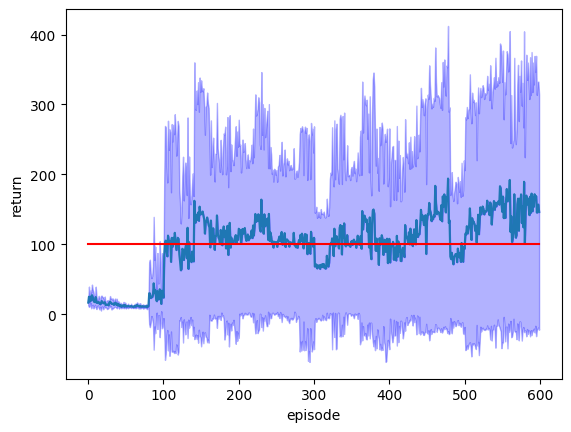

In [49]:
# Plot the results
res1 = torch.tensor(runs_results)
means = res1.float().mean(0)
stds = res1.float().std(0)
plt.clf()
# plt.figure()
plt.plot(torch.arange(600), means)
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(torch.arange(600), means, means + stds, alpha=0.3, color='b')
plt.fill_between(torch.arange(600), means, means - stds, alpha=0.3, color='b')
# baseline at 100
plt.plot(torch.arange(600), torch.ones(600)*100, color='r')

In [121]:
def plot_policy(policy_net, velocity):

    # import the model_DDQN_0.pth
    # model1 = DQN(layers)
    # model1.load_state_dict(torch.load("model_DDQN_9.pth"))
    # model1.eval()

    angle_range = .2095 # you may modify this range
    omega_range = 1     # you may modify this range

    angle_samples = 100
    omega_samples = 100
    angles = torch.linspace(angle_range, -angle_range, angle_samples)
    omegas = torch.linspace(-omega_range, omega_range, omega_samples)

    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., velocity, angle, omega])
            with torch.no_grad():
                q_values = policy_net(state)
                greedy_q_array[i, j] = q_values.max()
                policy_array[i, j] = q_values.argmax()

    # print(greedy_q_array)
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
    plt.colorbar()
    plt.xlabel("angle")
    plt.ylabel("omega")
    plt.title("Greedy Q-values")
    plt.savefig("DQN_{}_greedy_q_values.png".format(velocity))
    plt.show()


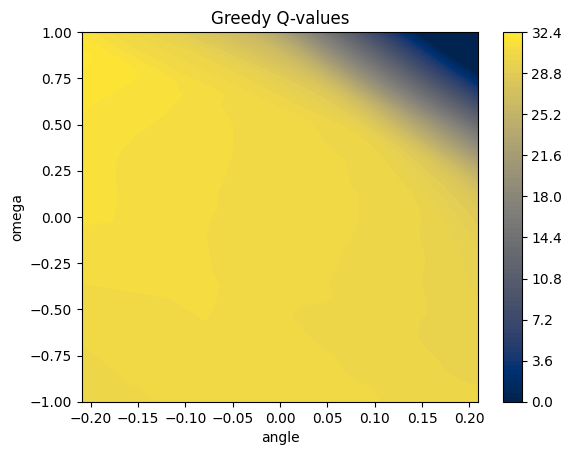

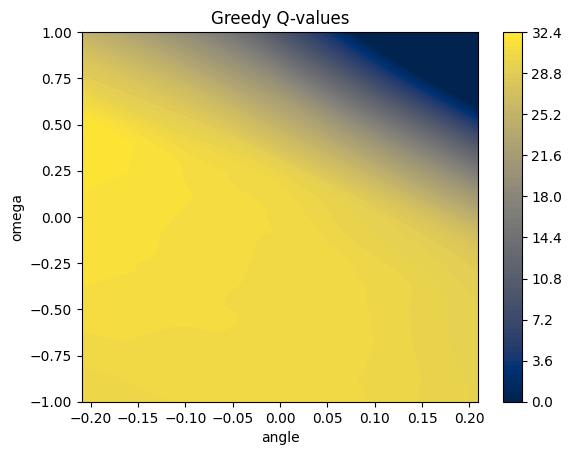

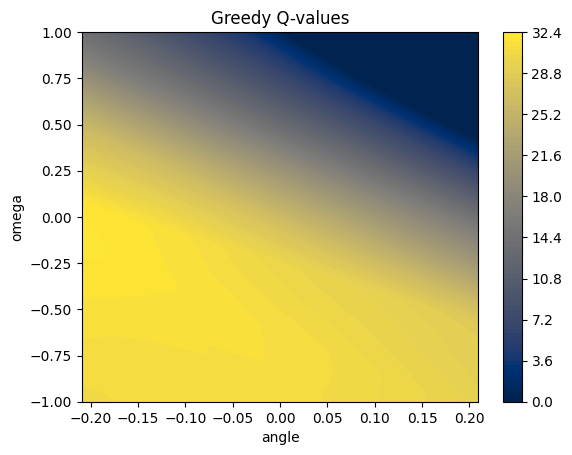

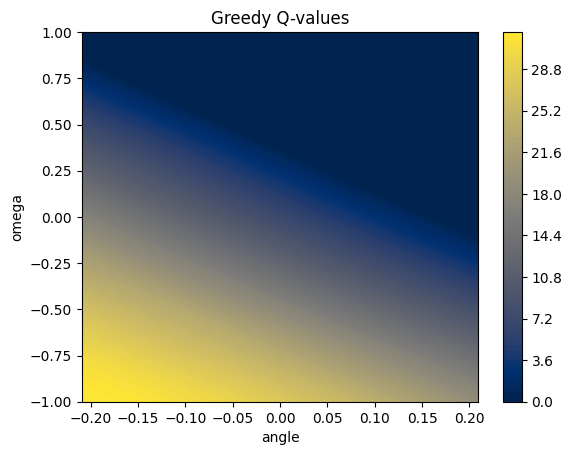

In [123]:
model1 = DQN(layers)
model1.load_state_dict(torch.load("model_DDQN_9.pth"))
model1.eval()

plot_policy(model1,0)
plot_policy(model1,0.5)
plot_policy(model1,1)
plot_policy(model1,2)